# __Upper Funnel - Awareness: Time Series Forecasting for Revenue__

## __Business Question:__
- When are the peak periods/key seasons for Resort and City Hotels?
- Understanding this will allow the Sales Department to take action by advertising to these customer segments earlier.

## __Business Action:__
- If we are able to forecast potential sales _(based on 'revenue')_ for a period, we can determine our marketing budget, as a percentage of spend, for that period to advertise.

## Agenda:

1. Import Data
2. Data Cleaning & Validation
3. Simple EDA
4. ARIMA - Resort Hotel (Daily)
5. SARIMAX - Resort Hotel (Daily)
6. ARIMA - City Hotel (Daily)
7. SARIMAX - City Hotel (Daily)
8. SARIMAX - Resort Hotel (Weekly)
9. SARIMAX - City Hotel (Weekly)
10. XGBoost - Resort Hotel (Daily)
11. XGBoost - City Hotel (Daily)

### __1. Import Data__

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score

import copy

In [2]:
df = pd.read_csv('hotel_bookings.csv', parse_dates=['reservation_status_date'])
df.head(3)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02


In [3]:
df_cleaned = copy.deepcopy(df)
df_cleaned.shape

(119390, 32)

### __2. Data Cleaning & Validation__

In [4]:
# Dropping the null rows for "children"

df_cleaned.dropna(subset=['country'],inplace=True)
df_cleaned.shape

(118902, 32)

In [5]:
# Filling in null values

fillna_values = {
    "children": 0,
    "agent": 0,
    "company": 0
}

df_cleaned.fillna(fillna_values,inplace=True)

In [6]:
# Replace values

df_cleaned['meal'].replace('Undefined', 'SC', inplace=True)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118902 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   hotel                           118902 non-null  object        
 1   is_canceled                     118902 non-null  int64         
 2   lead_time                       118902 non-null  int64         
 3   arrival_date_year               118902 non-null  int64         
 4   arrival_date_month              118902 non-null  object        
 5   arrival_date_week_number        118902 non-null  int64         
 6   arrival_date_day_of_month       118902 non-null  int64         
 7   stays_in_weekend_nights         118902 non-null  int64         
 8   stays_in_week_nights            118902 non-null  int64         
 9   adults                          118902 non-null  int64         
 10  children                        118902 non-null  float64

In [7]:
# Revenue column 
df_cleaned['revenue'] = df_cleaned['adr'] * (df_cleaned['stays_in_weekend_nights'] + df_cleaned['stays_in_week_nights'])

In [8]:
# Arrival Date
import datetime

df_cleaned['arrival_date_month_num'] = df_cleaned['arrival_date_month'].apply(lambda x: datetime.datetime.strptime(x, '%B').month)
df_cleaned['arrival_date_month_num'].head()
df_cleaned['arrival_date'] = pd.to_datetime(dict(year=df_cleaned['arrival_date_year'],month=df_cleaned['arrival_date_month_num'],day=df_cleaned['arrival_date_day_of_month']))

df_cleaned.drop(columns=['arrival_date_month_num'],inplace=True)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118902 entries, 0 to 119389
Data columns (total 34 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   hotel                           118902 non-null  object        
 1   is_canceled                     118902 non-null  int64         
 2   lead_time                       118902 non-null  int64         
 3   arrival_date_year               118902 non-null  int64         
 4   arrival_date_month              118902 non-null  object        
 5   arrival_date_week_number        118902 non-null  int64         
 6   arrival_date_day_of_month       118902 non-null  int64         
 7   stays_in_weekend_nights         118902 non-null  int64         
 8   stays_in_week_nights            118902 non-null  int64         
 9   adults                          118902 non-null  int64         
 10  children                        118902 non-null  float64

### __3. Simple EDA__

__I. Median Lead Time for Resort Hotel vs. City Hotel.__

In [9]:
# Resort Hotel

df_cleaned[df_cleaned['hotel']=='Resort Hotel']['lead_time'].describe()

count    39596.000000
mean        93.438857
std         97.387321
min          0.000000
25%         11.000000
50%         59.000000
75%        155.000000
max        737.000000
Name: lead_time, dtype: float64

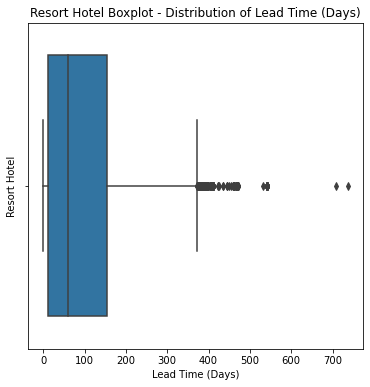

In [10]:
# Resort Hotel

fig, ax = plt.subplots(figsize=(6, 6))

sns.color_palette("viridis", as_cmap=True)
sns.boxplot(x=df_cleaned[df_cleaned['hotel']=='Resort Hotel']['lead_time'])

ax.set_title('Resort Hotel Boxplot - Distribution of Lead Time (Days)')
ax.set_xlabel('Lead Time (Days)')
ax.set_ylabel('Resort Hotel')


plt.show()

In [11]:
# City Hotel

df_cleaned[df_cleaned['hotel']=='City Hotel']['lead_time'].describe()

count    79306.000000
mean       109.734799
std        110.953017
min          0.000000
25%         23.000000
50%         74.000000
75%        163.000000
max        629.000000
Name: lead_time, dtype: float64

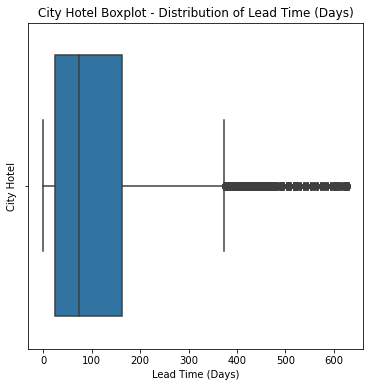

In [12]:
# City Hotel

fig, ax = plt.subplots(figsize=(6, 6))

sns.color_palette("viridis", as_cmap=True)
sns.boxplot(x=df_cleaned[df_cleaned['hotel']=='City Hotel']['lead_time'])

ax.set_title('City Hotel Boxplot - Distribution of Lead Time (Days)')
ax.set_xlabel('Lead Time (Days)')
ax.set_ylabel('City Hotel')


plt.show()

__II. Median Average Daily Rate over Month for Resort Hotel vs. City Hotel__

In [13]:
# Resort Hotel ADR

months = ["January", "February", "March", "April", "May", "June", 
          "July", "August", "September", "October", "November", "December"]
df_cleaned[df_cleaned['hotel']=='Resort Hotel'].groupby(by='arrival_date_month')['adr'].median().sort_index(key = lambda x: pd.Categorical(x,categories=months,ordered=True))

arrival_date_month
January       48.00
February      52.00
March         55.80
April         75.15
May           73.00
June         105.00
July         152.86
August       188.71
September     86.00
October       58.00
November      45.00
December      58.00
Name: adr, dtype: float64

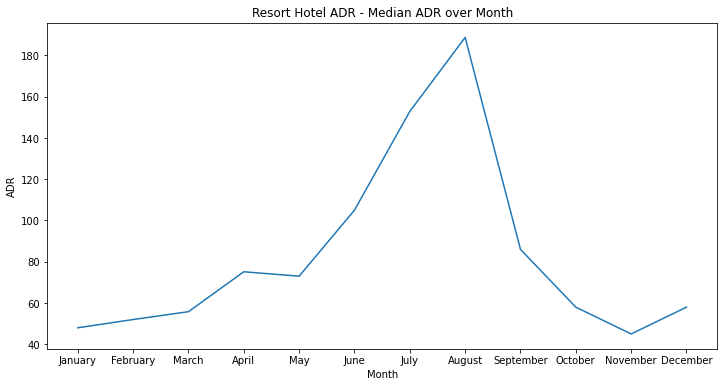

In [14]:
# Resort Hotel ADR

fig, ax = plt.subplots(figsize=(12, 6))

sns.color_palette("viridis", as_cmap=True)
sns.lineplot(data=df_cleaned[df_cleaned['hotel']=='Resort Hotel'].groupby(by='arrival_date_month')['adr'].median().sort_index(key = lambda x: pd.Categorical(x,categories=months,ordered=True)))

ax.set_title('Resort Hotel ADR - Median ADR over Month')
ax.set_xlabel('Month')
ax.set_ylabel('ADR')


plt.show()

In [15]:
# City Hotel ADR

df_cleaned[df_cleaned['hotel']=='City Hotel'].groupby(by='arrival_date_month')['adr'].median().sort_index(key = lambda x: pd.Categorical(x,categories=months,ordered=True))

arrival_date_month
January       80.00
February      80.00
March         88.00
April        105.00
May          120.00
June         117.37
July         107.10
August       109.00
September    107.00
October      100.00
November      85.00
December      85.00
Name: adr, dtype: float64

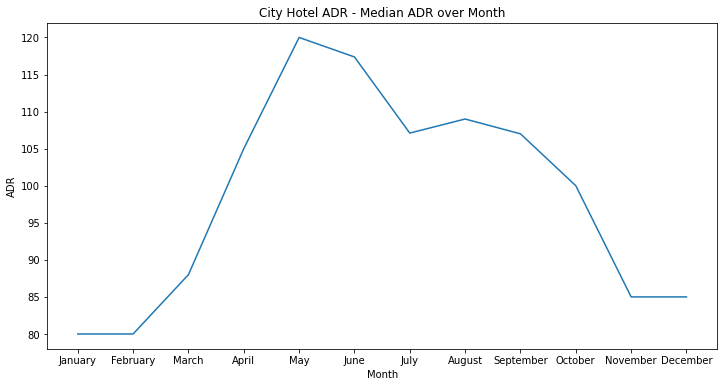

In [16]:
# City Hotel ADR

fig, ax = plt.subplots(figsize=(12, 6))

sns.color_palette("viridis", as_cmap=True)
sns.lineplot(data=df_cleaned[df_cleaned['hotel']=='City Hotel'].groupby(by='arrival_date_month')['adr'].median().sort_index(key = lambda x: pd.Categorical(x,categories=months,ordered=True)))

ax.set_title('City Hotel ADR - Median ADR over Month')
ax.set_xlabel('Month')
ax.set_ylabel('ADR')


plt.show()

__III. Total Bookings over Month for Resort Hotel vs. City Hotel__

In [17]:
# Resort Hotel

df_cleaned[df_cleaned['hotel']=='Resort Hotel'].groupby(by='arrival_date_month')['adr'].count().sort_index(key = lambda x: pd.Categorical(x,categories=months,ordered=True))

arrival_date_month
January      2138
February     3047
March        3281
April        3569
May          3547
June         3033
July         4540
August       4873
September    3067
October      3504
November     2398
December     2599
Name: adr, dtype: int64

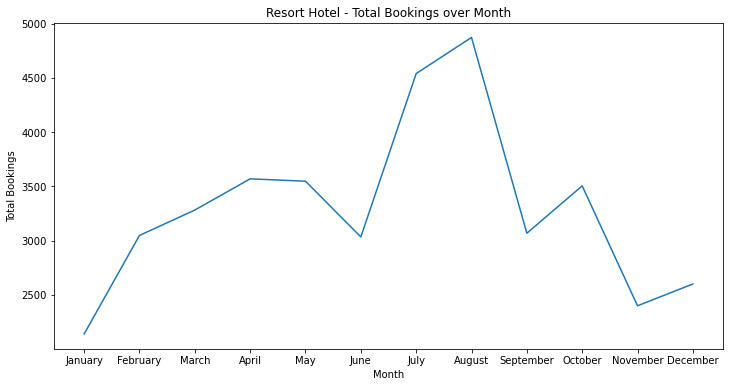

In [18]:
# Resort Hotel Total Bookings

fig, ax = plt.subplots(figsize=(12, 6))

sns.color_palette("viridis", as_cmap=True)
sns.lineplot(data=df_cleaned[df_cleaned['hotel']=='Resort Hotel'].groupby(by='arrival_date_month')['adr'].count().sort_index(key = lambda x: pd.Categorical(x,categories=months,ordered=True)))

ax.set_title('Resort Hotel - Total Bookings over Month')
ax.set_xlabel('Month')
ax.set_ylabel('Total Bookings')


plt.show()

In [19]:
# City Hotel

df_cleaned[df_cleaned['hotel']=='City Hotel'].groupby(by='arrival_date_month')['adr'].count().sort_index(key = lambda x: pd.Categorical(x,categories=months,ordered=True))

arrival_date_month
January      3736
February     4965
March        6458
April        7476
May          8232
June         7894
July         8088
August       8983
September    7400
October      7591
November     4354
December     4129
Name: adr, dtype: int64

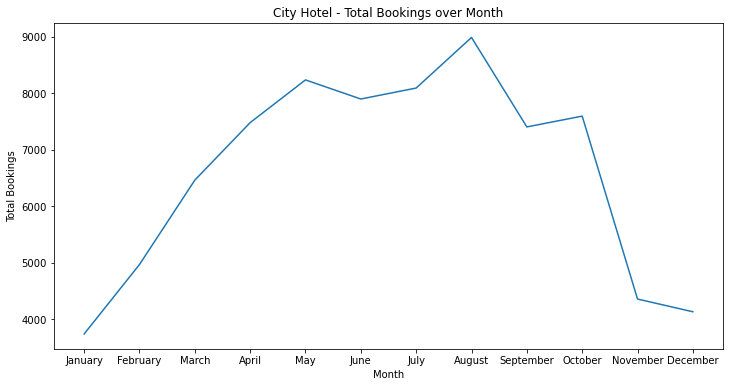

In [20]:
# City Hotel Total Bookings

fig, ax = plt.subplots(figsize=(12, 6))

sns.color_palette("viridis", as_cmap=True)
sns.lineplot(data=df_cleaned[df_cleaned['hotel']=='City Hotel'].groupby(by='arrival_date_month')['adr'].count().sort_index(key = lambda x: pd.Categorical(x,categories=months,ordered=True)))

ax.set_title('City Hotel - Total Bookings over Month')
ax.set_xlabel('Month')
ax.set_ylabel('Total Bookings')


plt.show()

__IV. Descriptive Statistics for Revenue of Resort Hotel vs. City Hotel__

_This will come in handy when evaluating which Time Series Forecasting model is good enough._

In [21]:
# Resort Hotel (Daily)

df_cleaned_datetime_resort_daily = df_cleaned[df_cleaned['hotel']=='Resort Hotel'][['arrival_date','revenue']]
df_cleaned_datetime_resort_daily.sort_values(by='arrival_date', ascending=True, inplace=True)
df_cleaned_datetime_resort_daily_grouped = df_cleaned_datetime_resort_daily.groupby(by='arrival_date')['revenue'].sum()
df_cleaned_datetime_resort_daily_grouped.describe()

count       793.000000
mean      21872.257276
std       18661.515347
min         678.150000
25%        7806.420000
50%       16489.990000
75%       29523.140000
max      106332.360000
Name: revenue, dtype: float64

In [22]:
# City Hotel (Daily)

df_cleaned_datetime_city_daily = df_cleaned[df_cleaned['hotel']=='City Hotel'][['arrival_date','revenue']]
df_cleaned_datetime_city_daily.sort_values(by='arrival_date', ascending=True, inplace=True)
df_cleaned_datetime_city_daily_grouped = df_cleaned_datetime_city_daily.groupby(by='arrival_date')['revenue'].sum()
df_cleaned_datetime_city_daily_grouped.describe()

count       793.000000
mean      31874.035259
std       19479.658124
min         535.500000
25%       16987.200000
50%       30501.400000
75%       43466.870000
max      154186.400000
Name: revenue, dtype: float64

### __4. ARIMA - Resort Hotel (Daily)__

In [23]:
df_cleaned_datetime_resort_daily = df_cleaned[df_cleaned['hotel']=='Resort Hotel'][['arrival_date','revenue']]
df_cleaned_datetime_resort_daily.sort_values(by='arrival_date', ascending=True, inplace=True)
df_cleaned_datetime_resort_daily.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39596 entries, 0 to 40059
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   arrival_date  39596 non-null  datetime64[ns]
 1   revenue       39596 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 928.0 KB


In [24]:
df_cleaned_datetime_resort_daily_grouped = df_cleaned_datetime_resort_daily.groupby(by='arrival_date')['revenue'].sum()
df_cleaned_datetime_resort_daily_grouped.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 793 entries, 2015-07-01 to 2017-08-31
Series name: revenue
Non-Null Count  Dtype  
--------------  -----  
793 non-null    float64
dtypes: float64(1)
memory usage: 12.4 KB


<AxesSubplot:xlabel='arrival_date'>

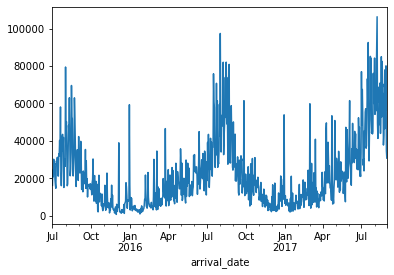

In [25]:
df_cleaned_datetime_resort_daily_grouped.plot()

In [26]:
# We want to train on historical data and forecast later dates

# Time Unit: Daily
df_cleaned_datetime_resort_daily_grouped_train = df_cleaned_datetime_resort_daily_grouped[:700]
df_cleaned_datetime_resort_daily_grouped_test = df_cleaned_datetime_resort_daily_grouped[700:]

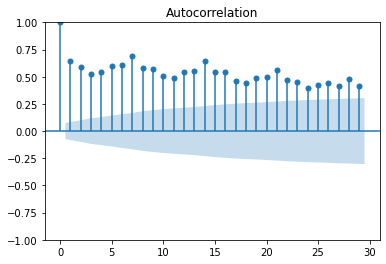

In [27]:
acf_resort_daily_train = plot_acf(df_cleaned_datetime_resort_daily_grouped_train)

C:\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


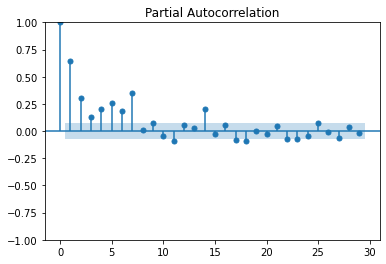

In [28]:
pacf_resort_daily_train = plot_pacf(df_cleaned_datetime_resort_daily_grouped_train)

In [29]:
adf_resort_daily_train = adfuller(df_cleaned_datetime_resort_daily_grouped_train)
print(f'p-value: {adf_resort_daily_train[1]}')

p-value: 0.2308014248516509


Time Series is not stationary, let's fix it through differencing.

<AxesSubplot:xlabel='arrival_date'>

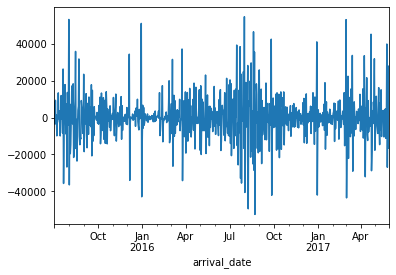

In [30]:
df_cleaned_datetime_resort_daily_grouped_train_diff = df_cleaned_datetime_resort_daily_grouped_train.diff().dropna()
df_cleaned_datetime_resort_daily_grouped_train_diff.plot()

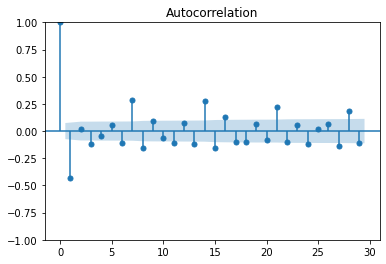

In [31]:
acf_resort_daily_train_diff = plot_acf(df_cleaned_datetime_resort_daily_grouped_train_diff)

C:\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


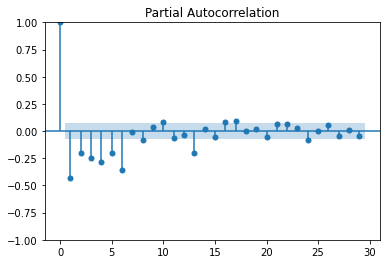

In [32]:
pacf_resort_daily_train_diff = plot_pacf(df_cleaned_datetime_resort_daily_grouped_train_diff)

In [33]:
adf_resort_daily_train_diff = adfuller(df_cleaned_datetime_resort_daily_grouped_train_diff)
print(f'p-value: {adf_resort_daily_train_diff[1]}')

p-value: 3.326545574634782e-11


Now, time series is stationary. We can use __ARIMA(2,1,2).__

In [34]:
model_resort_daily_arima = ARIMA(df_cleaned_datetime_resort_daily_grouped_train, order=(2,1,2)) # Notice we are using the original training dataset before differencing
model_resort_daily_arima_fit = model_resort_daily_arima.fit()

print(model_resort_daily_arima_fit.summary())

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-in

                               SARIMAX Results                                
Dep. Variable:                revenue   No. Observations:                  700
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -7449.215
Date:                Mon, 20 Mar 2023   AIC                          14908.431
Time:                        21:19:09   BIC                          14931.179
Sample:                    07-01-2015   HQIC                         14917.225
                         - 05-30-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3339      0.940     -0.355      0.722      -2.176       1.508
ar.L2          0.0758      0.097      0.782      0.434      -0.114       0.266
ma.L1         -0.4195      0.945     -0.444      0.6

<AxesSubplot:>

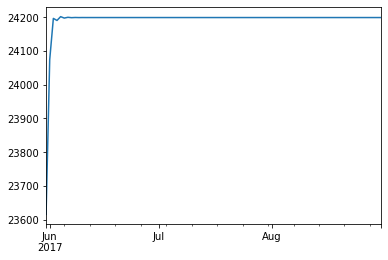

In [35]:
# Time Unit: Daily
forecast_resort_daily_arima_test = model_resort_daily_arima_fit.predict(start=df_cleaned_datetime_resort_daily_grouped_test.index[0],end=df_cleaned_datetime_resort_daily_grouped_test.index[-1])
forecast_resort_daily_arima_test.plot()

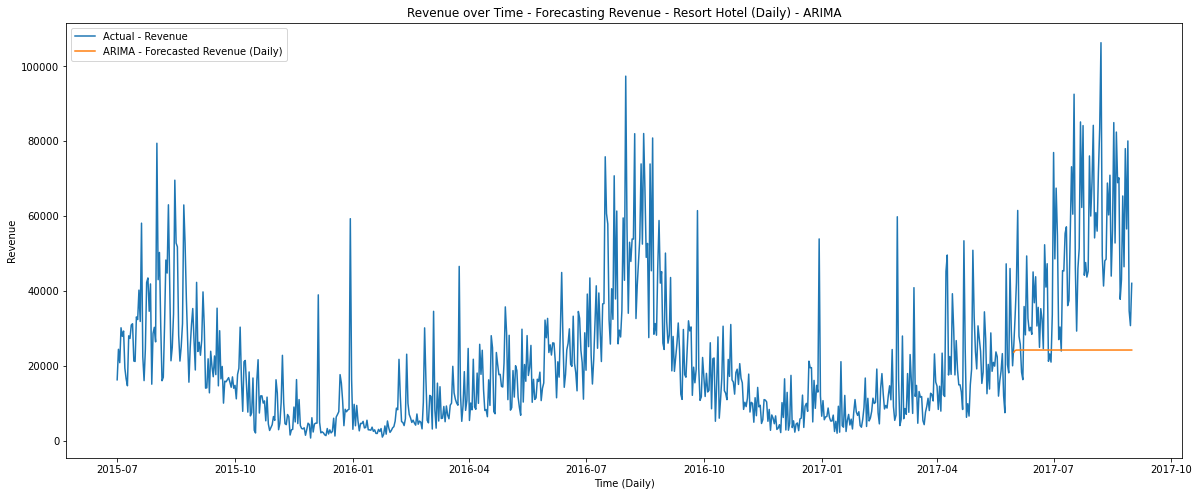

In [36]:
fig, ax = plt.subplots(figsize=(20, 8))

sns.color_palette("viridis", as_cmap=True)
sns.lineplot(data=df_cleaned_datetime_resort_daily_grouped, label='Actual - Revenue')
sns.lineplot(data=forecast_resort_daily_arima_test, label='ARIMA - Forecasted Revenue (Daily)')

ax.set_title('Revenue over Time - Forecasting Revenue - Resort Hotel (Daily) - ARIMA')
ax.set_xlabel('Time (Daily)')
ax.set_ylabel('Revenue')
ax.legend(loc='upper left')

plt.show()

In [37]:
mae_resort_daily_arima = mean_absolute_error(df_cleaned_datetime_resort_daily_grouped_test,forecast_resort_daily_arima_test)
mse_resort_daily_arima = mean_squared_error(df_cleaned_datetime_resort_daily_grouped_test,forecast_resort_daily_arima_test)
rmse_resort_daily_arima = mean_squared_error(df_cleaned_datetime_resort_daily_grouped_test,forecast_resort_daily_arima_test, squared=False)

# Print the evaluation metrics
print("Resort Hotel (Daily) - ARIMA - Evaluating Resort Hotel (Daily) - Revenue Forecasting:")
print(f"Resort Hotel (Daily) - ARIMA - Mean Absolute Error: {mae_resort_daily_arima}.")
print(f"Resort Hotel (Daily) - ARIMA - Mean Squared Error: {mse_resort_daily_arima}.")
print(f"Resort Hotel (Daily) - ARIMA - Root Mean Squared Error: {rmse_resort_daily_arima}.")

Resort Hotel (Daily) - ARIMA - Evaluating Resort Hotel (Daily) - Revenue Forecasting:
Resort Hotel (Daily) - ARIMA - Mean Absolute Error: 25612.707491555237.
Resort Hotel (Daily) - ARIMA - Mean Squared Error: 1006592343.389627.
Resort Hotel (Daily) - ARIMA - Root Mean Squared Error: 31726.83947999906.


### __5. SARIMAX - Resort Hotel (Daily)__

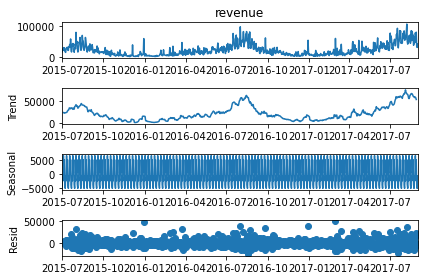

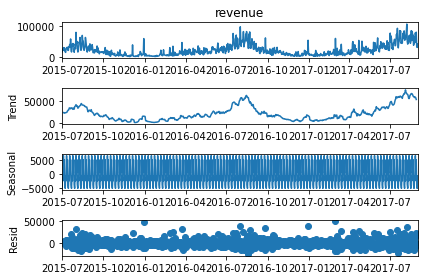

In [38]:
decomposed_data_resort_daily = seasonal_decompose(df_cleaned_datetime_resort_daily_grouped)
decomposed_data_resort_daily.plot()

In [39]:
model_resort_daily_sarimax = SARIMAX(df_cleaned_datetime_resort_daily_grouped, order=(2,1,2), seasonal_order=(2,1,2,12), trend='ct')
model_resort_daily_sarimax_fit = model_resort_daily_sarimax.fit()

print(model_resort_daily_sarimax_fit.summary())

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                            revenue   No. Observations:                  793
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood               -8436.069
Date:                            Mon, 20 Mar 2023   AIC                          16894.138
Time:                                    21:19:27   BIC                          16945.390
Sample:                                07-01-2015   HQIC                         16913.850
                                     - 08-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     40.7904     59.872      0.681      0.496     -76.556     158.137
drift         -0.0715      0.130   

<AxesSubplot:>

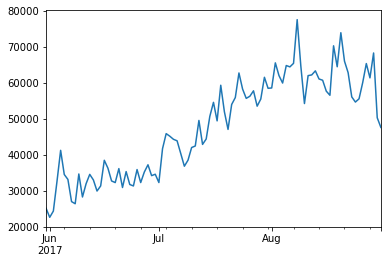

In [40]:
# Time Unit: Daily
forecast_resort_daily_sarimax_test = model_resort_daily_sarimax_fit.predict(start=df_cleaned_datetime_resort_daily_grouped_test.index[0],end=df_cleaned_datetime_resort_daily_grouped_test.index[-1])
forecast_resort_daily_sarimax_test.plot()

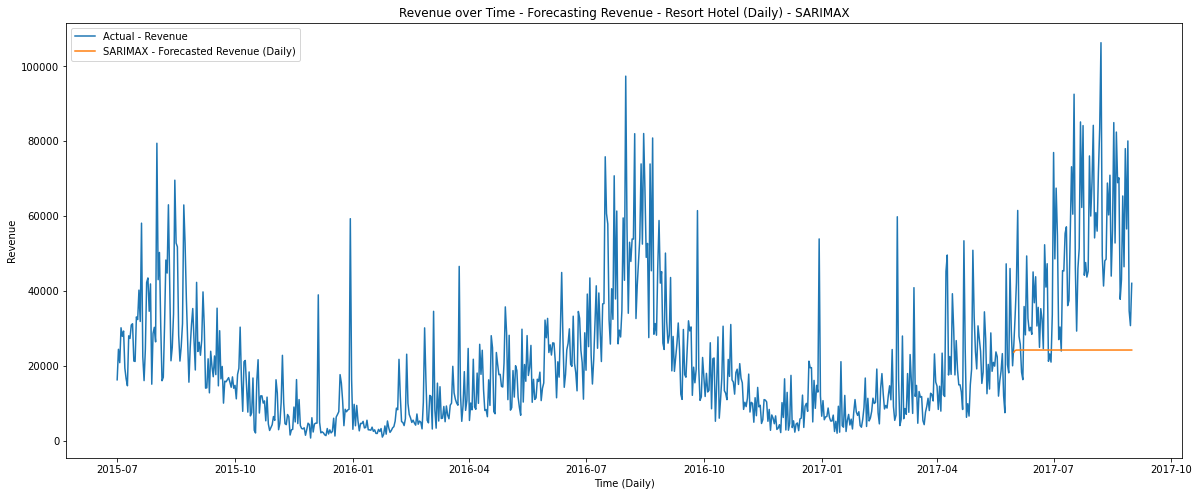

In [41]:
fig, ax = plt.subplots(figsize=(20, 8))

sns.color_palette("viridis", as_cmap=True)
sns.lineplot(data=df_cleaned_datetime_resort_daily_grouped, label='Actual - Revenue')
sns.lineplot(data=forecast_resort_daily_arima_test, label='SARIMAX - Forecasted Revenue (Daily)')

ax.set_title('Revenue over Time - Forecasting Revenue - Resort Hotel (Daily) - SARIMAX')
ax.set_xlabel('Time (Daily)')
ax.set_ylabel('Revenue')
ax.legend(loc='upper left')

plt.show()

In [42]:
mae_resort_daily_sarimax = mean_absolute_error(df_cleaned_datetime_resort_daily_grouped_test,forecast_resort_daily_sarimax_test)
mse_resort_daily_sarimax = mean_squared_error(df_cleaned_datetime_resort_daily_grouped_test,forecast_resort_daily_sarimax_test)
rmse_resort_daily_sarimax = mean_squared_error(df_cleaned_datetime_resort_daily_grouped_test,forecast_resort_daily_sarimax_test, squared=False)

# Print the evaluation metrics
print("Resort Hotel (Daily) - SARIMAX - Evaluating Resort Hotel (Daily) - Revenue Forecasting:")
print(f"Resort Hotel (Daily) - SARIMAX - Mean Absolute Error: {mae_resort_daily_sarimax}.")
print(f"Resort Hotel (Daily) - SARIMAX - Mean Squared Error: {mse_resort_daily_sarimax}.")
print(f"Resort Hotel (Daily) - SARIMAX - Root Mean Squared Error: {rmse_resort_daily_sarimax}.")

Resort Hotel (Daily) - SARIMAX - Evaluating Resort Hotel (Daily) - Revenue Forecasting:
Resort Hotel (Daily) - SARIMAX - Mean Absolute Error: 12791.25856598391.
Resort Hotel (Daily) - SARIMAX - Mean Squared Error: 254903028.0604316.
Resort Hotel (Daily) - SARIMAX - Root Mean Squared Error: 15965.68282474732.


### __6. ARIMA - City Hotel (Daily)__

In [43]:
df_cleaned_datetime_city_daily = df_cleaned[df_cleaned['hotel']=='City Hotel'][['arrival_date','revenue']]
df_cleaned_datetime_city_daily.sort_values(by='arrival_date', ascending=True, inplace=True)
df_cleaned_datetime_city_daily.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79306 entries, 40060 to 119312
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   arrival_date  79306 non-null  datetime64[ns]
 1   revenue       79306 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.8 MB


In [44]:
df_cleaned_datetime_city_daily_grouped = df_cleaned_datetime_city_daily.groupby(by='arrival_date')['revenue'].sum()
df_cleaned_datetime_city_daily_grouped.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 793 entries, 2015-07-01 to 2017-08-31
Series name: revenue
Non-Null Count  Dtype  
--------------  -----  
793 non-null    float64
dtypes: float64(1)
memory usage: 12.4 KB


<AxesSubplot:xlabel='arrival_date'>

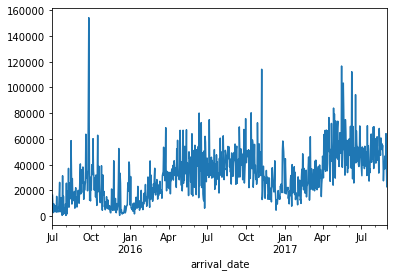

In [45]:
df_cleaned_datetime_city_daily_grouped.plot()

In [46]:
# We want to train on historical data and forecast later dates

# Time Unit: Daily
df_cleaned_datetime_city_daily_grouped_train = df_cleaned_datetime_city_daily_grouped[:700]
df_cleaned_datetime_city_daily_grouped_test = df_cleaned_datetime_city_daily_grouped[700:]

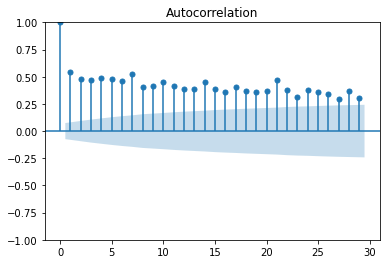

In [47]:
acf_city_daily_train = plot_acf(df_cleaned_datetime_city_daily_grouped_train)

C:\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


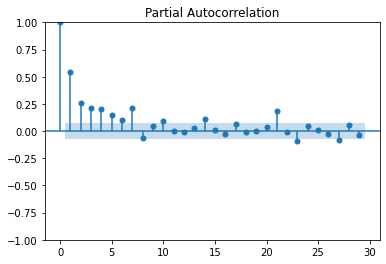

In [48]:
pacf_city_daily_train = plot_pacf(df_cleaned_datetime_city_daily_grouped_train)

In [49]:
adf_city_daily_train = adfuller(df_cleaned_datetime_city_daily_grouped_train)
print(f'p-value: {adf_city_daily_train[1]}')

p-value: 0.5293654240949733


<AxesSubplot:xlabel='arrival_date'>

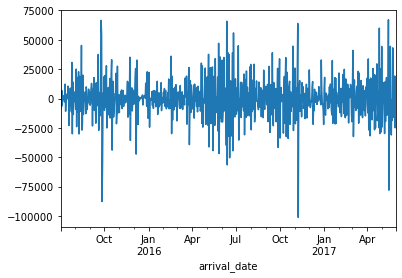

In [50]:
df_cleaned_datetime_city_daily_grouped_train_diff = df_cleaned_datetime_city_daily_grouped_train.diff().dropna()
df_cleaned_datetime_city_daily_grouped_train_diff.plot()

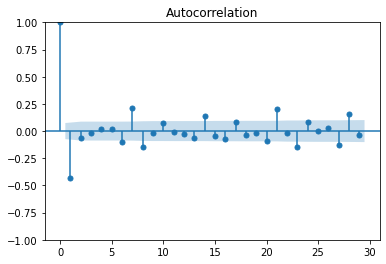

In [51]:
acf_city_daily_train_diff = plot_acf(df_cleaned_datetime_city_daily_grouped_train_diff)

C:\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


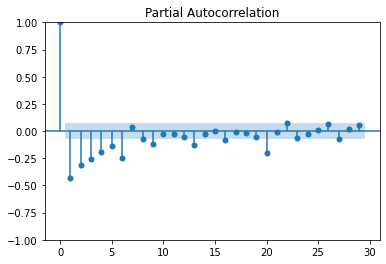

In [52]:
pacf_city_daily_train_diff = plot_pacf(df_cleaned_datetime_city_daily_grouped_train_diff)

In [53]:
adf_city_daily_train_diff = adfuller(df_cleaned_datetime_city_daily_grouped_train_diff)
print(f'p-value: {adf_city_daily_train_diff[1]}')

p-value: 3.475880009085468e-18


In [54]:
model_city_daily_arima = ARIMA(df_cleaned_datetime_city_daily_grouped_train, order=(2,1,2)) # Notice we are using the original training dataset before differencing
model_city_daily_arima_fit = model_city_daily_arima.fit()

print(model_city_daily_arima_fit.summary())

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-in

                               SARIMAX Results                                
Dep. Variable:                revenue   No. Observations:                  700
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -7675.040
Date:                Mon, 20 Mar 2023   AIC                          15360.079
Time:                        21:19:30   BIC                          15382.828
Sample:                    07-01-2015   HQIC                         15368.874
                         - 05-30-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7833      0.140     -5.611      0.000      -1.057      -0.510
ar.L2          0.0576      0.046      1.251      0.211      -0.033       0.148
ma.L1         -0.0012      0.135     -0.009      0.9

<AxesSubplot:>

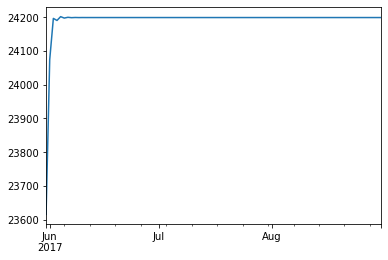

In [55]:
# Time Unit: Daily
forecast_city_daily_arima_test = model_resort_daily_arima_fit.predict(start=df_cleaned_datetime_resort_daily_grouped_test.index[0],end=df_cleaned_datetime_resort_daily_grouped_test.index[-1])
forecast_city_daily_arima_test.plot()

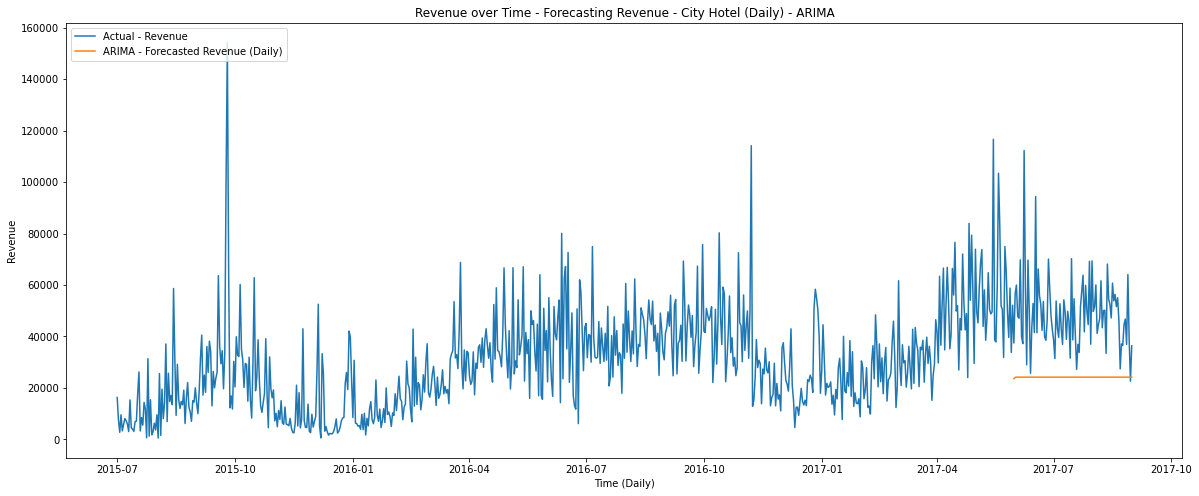

In [56]:
fig, ax = plt.subplots(figsize=(20, 8))

sns.color_palette("viridis", as_cmap=True)
sns.lineplot(data=df_cleaned_datetime_city_daily_grouped, label='Actual - Revenue')
sns.lineplot(data=forecast_city_daily_arima_test, label='ARIMA - Forecasted Revenue (Daily)')

ax.set_title('Revenue over Time - Forecasting Revenue - City Hotel (Daily) - ARIMA')
ax.set_xlabel('Time (Daily)')
ax.set_ylabel('Revenue')
ax.legend(loc='upper left')

plt.show()

In [57]:
mae_city_daily_arima = mean_absolute_error(df_cleaned_datetime_city_daily_grouped_test,forecast_city_daily_arima_test)
mse_city_daily_arima = mean_squared_error(df_cleaned_datetime_city_daily_grouped_test,forecast_city_daily_arima_test)
rmse_city_daily_arima = mean_squared_error(df_cleaned_datetime_city_daily_grouped_test,forecast_city_daily_arima_test, squared=False)

# Print the evaluation metrics
print("City Hotel (Daily) - ARIMA - Evaluating Resort Hotel (Daily) - Revenue Forecasting:")
print(f"City Hotel (Daily) - ARIMA - Mean Absolute Error: {mae_city_daily_arima}.")
print(f"City Hotel (Daily) - ARIMA - Mean Squared Error: {mse_city_daily_arima}.")
print(f"City Hotel (Daily) - ARIMA - Root Mean Squared Error: {rmse_city_daily_arima}.")

City Hotel (Daily) - ARIMA - Evaluating Resort Hotel (Daily) - Revenue Forecasting:
City Hotel (Daily) - ARIMA - Mean Absolute Error: 24840.50665547169.
City Hotel (Daily) - ARIMA - Mean Squared Error: 803282297.6688774.
City Hotel (Daily) - ARIMA - Root Mean Squared Error: 28342.23522711075.


### __7. SARIMAX - City Hotel (Daily)__

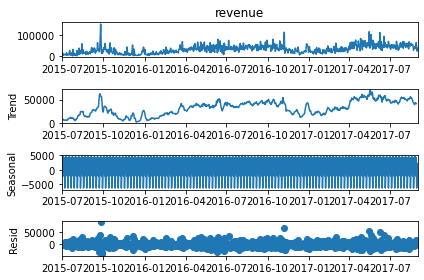

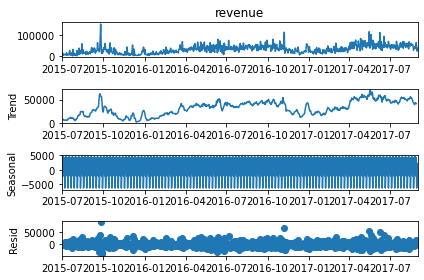

In [58]:
decomposed_data_city_daily = seasonal_decompose(df_cleaned_datetime_city_daily_grouped)
decomposed_data_city_daily.plot()

In [59]:
model_city_daily_sarimax = SARIMAX(df_cleaned_datetime_city_daily_grouped, order=(2,1,2), seasonal_order=(2,1,2,12), trend='ct')
model_city_daily_sarimax_fit = model_city_daily_sarimax.fit()

print(model_city_daily_sarimax_fit.summary())

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                            revenue   No. Observations:                  793
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood               -8672.743
Date:                            Mon, 20 Mar 2023   AIC                          17367.486
Time:                                    21:19:38   BIC                          17418.738
Sample:                                07-01-2015   HQIC                         17387.198
                                     - 08-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     61.8975    223.853      0.277      0.782    -376.846     500.641
drift         -0.1521      0.521   

<AxesSubplot:>

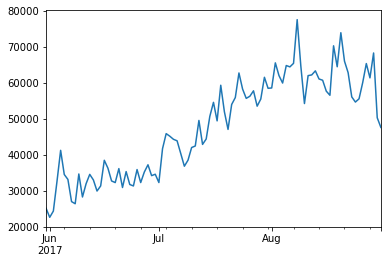

In [60]:
# Time Unit: Daily
forecast_city_daily_sarimax_test = model_resort_daily_sarimax_fit.predict(start=df_cleaned_datetime_city_daily_grouped_test.index[0],end=df_cleaned_datetime_city_daily_grouped_test.index[-1])
forecast_city_daily_sarimax_test.plot()

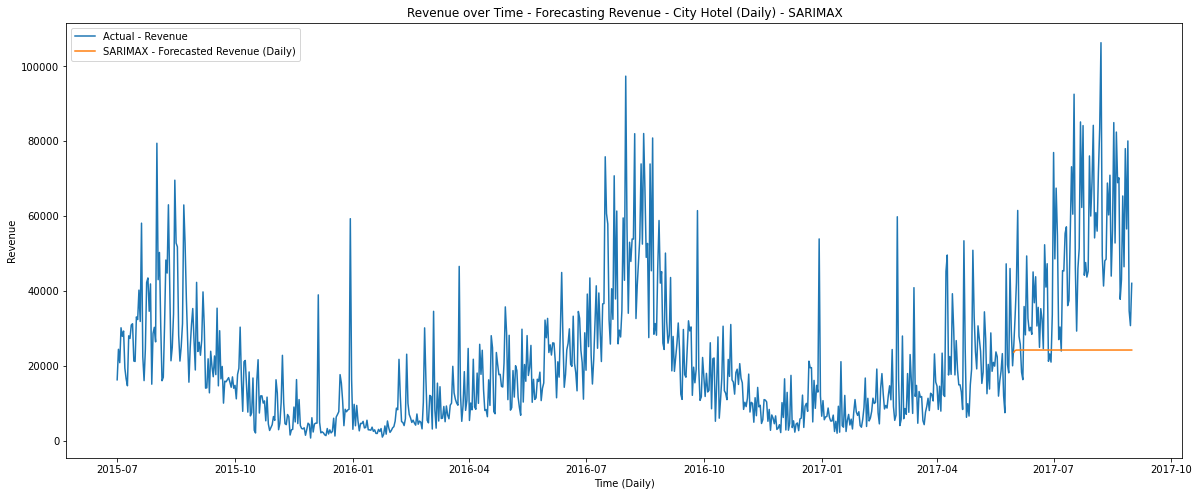

In [61]:
fig, ax = plt.subplots(figsize=(20, 8))

sns.color_palette("viridis", as_cmap=True)
sns.lineplot(data=df_cleaned_datetime_resort_daily_grouped, label='Actual - Revenue')
sns.lineplot(data=forecast_resort_daily_arima_test, label='SARIMAX - Forecasted Revenue (Daily)')

ax.set_title('Revenue over Time - Forecasting Revenue - City Hotel (Daily) - SARIMAX')
ax.set_xlabel('Time (Daily)')
ax.set_ylabel('Revenue')
ax.legend(loc='upper left')

plt.show()

In [62]:
mae_city_daily_sarimax = mean_absolute_error(df_cleaned_datetime_city_daily_grouped_test,forecast_city_daily_sarimax_test)
mse_city_daily_sarimax = mean_squared_error(df_cleaned_datetime_city_daily_grouped_test,forecast_city_daily_sarimax_test)
rmse_city_daily_sarimax = mean_squared_error(df_cleaned_datetime_city_daily_grouped_test,forecast_city_daily_sarimax_test, squared=False)

# Print the evaluation metrics
print("City Hotel (Daily) - SARIMAX - Evaluating Resort Hotel (Daily) - Revenue Forecasting:")
print(f"City Hotel (Daily) - SARIMAX - Mean Absolute Error: {mae_city_daily_sarimax}.")
print(f"City Hotel (Daily) - SARIMAX - Mean Squared Error: {mse_city_daily_sarimax}.")
print(f"City Hotel (Daily) - SARIMAX - Root Mean Squared Error: {rmse_city_daily_sarimax}.")

City Hotel (Daily) - SARIMAX - Evaluating Resort Hotel (Daily) - Revenue Forecasting:
City Hotel (Daily) - SARIMAX - Mean Absolute Error: 15169.851997595342.
City Hotel (Daily) - SARIMAX - Mean Squared Error: 398123547.7771075.
City Hotel (Daily) - SARIMAX - Root Mean Squared Error: 19953.03354823791.


### __Quick Summary:__

It appeards that based on __RMSE,__ our __SARIMAX Model is better:__
1. Resort Hotel (Daily) - ARIMA: 31,726.8394
2. Resort Hotel (Daily) - SARIMAX: 15,965.6828
3. City Hotel (Daily) - ARIMA: 28,342.2352
4. City Hotel (Daily) - SARIMAX: 19,953.0335

Now, let's aggregate the __Time Unit from Daily to Weekly.__

### __8. SARIMAX - Resort Hotel (Weekly)__

In [63]:
df_cleaned_datetime_resort_weekly = df_cleaned[df_cleaned['hotel']=='Resort Hotel'][['arrival_date','revenue']]
df_cleaned_datetime_resort_weekly.sort_values(by='arrival_date', ascending=True, inplace=True)

In [64]:
df_cleaned_datetime_resort_weekly['arrival_year_month_week'] = df_cleaned_datetime_resort_weekly['arrival_date'].dt.strftime('%Y-%m-W%U')
df_cleaned_datetime_resort_weekly.drop(axis=1,columns='arrival_date',inplace=True)
df_cleaned_datetime_resort_weekly.sort_values(by='arrival_year_month_week', ascending=True, inplace=True)
df_cleaned_datetime_resort_weekly.head()

,revenue,arrival_year_month_week
0,0.0,2015-07-W26
77,488.0,2015-07-W26
82,556.8,2015-07-W26
91,123.0,2015-07-W26
90,131.0,2015-07-W26


In [65]:
df_cleaned_datetime_resort_weekly_grouped = df_cleaned_datetime_resort_weekly.groupby(by='arrival_year_month_week')['revenue'].sum()
df_cleaned_datetime_resort_weekly_grouped.info()

<class 'pandas.core.series.Series'>
Index: 136 entries, 2015-07-W26 to 2017-08-W35
Series name: revenue
Non-Null Count  Dtype  
--------------  -----  
136 non-null    float64
dtypes: float64(1)
memory usage: 2.1+ KB


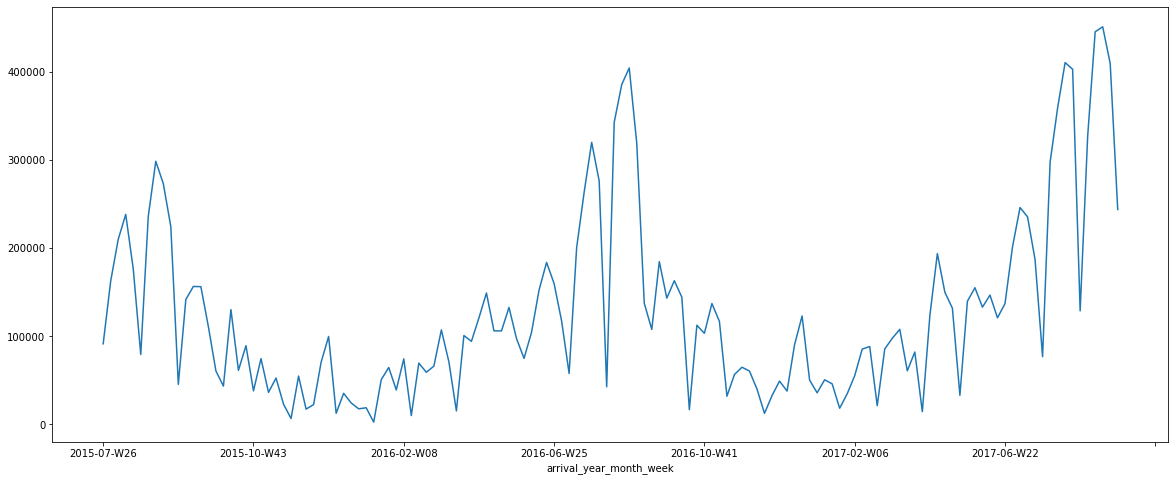

In [66]:
fig, ax = plt.subplots(figsize=(20, 8))
df_cleaned_datetime_resort_weekly_grouped.plot()
plt.show()

In [67]:
# We want to train on historical data and forecast later dates

# Time Unit: Weekly
df_cleaned_datetime_resort_weekly_grouped_train = df_cleaned_datetime_resort_weekly_grouped[:106]
df_cleaned_datetime_resort_weekly_grouped_test = df_cleaned_datetime_resort_weekly_grouped[106:]

In [68]:
model_resort_weekly_sarimax = SARIMAX(df_cleaned_datetime_resort_weekly_grouped, order=(2,1,2), seasonal_order=(2,1,2,12), trend='ct')
model_resort_weekly_sarimax_fit = model_resort_weekly_sarimax.fit()

print(model_resort_weekly_sarimax_fit.summary())

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                            revenue   No. Observations:                  136
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood               -1550.833
Date:                            Mon, 20 Mar 2023   AIC                           3123.667
Time:                                    21:19:41   BIC                           3154.601
Sample:                                         0   HQIC                          3136.232
                                            - 136                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   6584.9587   1.72e+04      0.382      0.702   -2.72e+04    4.04e+04
drift        -61.7092    196.307   

<AxesSubplot:xlabel='arrival_year_month_week'>

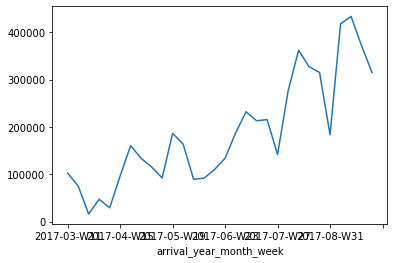

In [69]:
# Time Unit: Monthly
forecast_resort_weekly_sarimax_test = model_resort_weekly_sarimax_fit.predict(start=len(df_cleaned_datetime_resort_weekly_grouped_train),
                                                                                end=len(df_cleaned_datetime_resort_weekly_grouped_train)+len(df_cleaned_datetime_resort_weekly_grouped_test)-1)
forecast_resort_weekly_sarimax_test.plot()

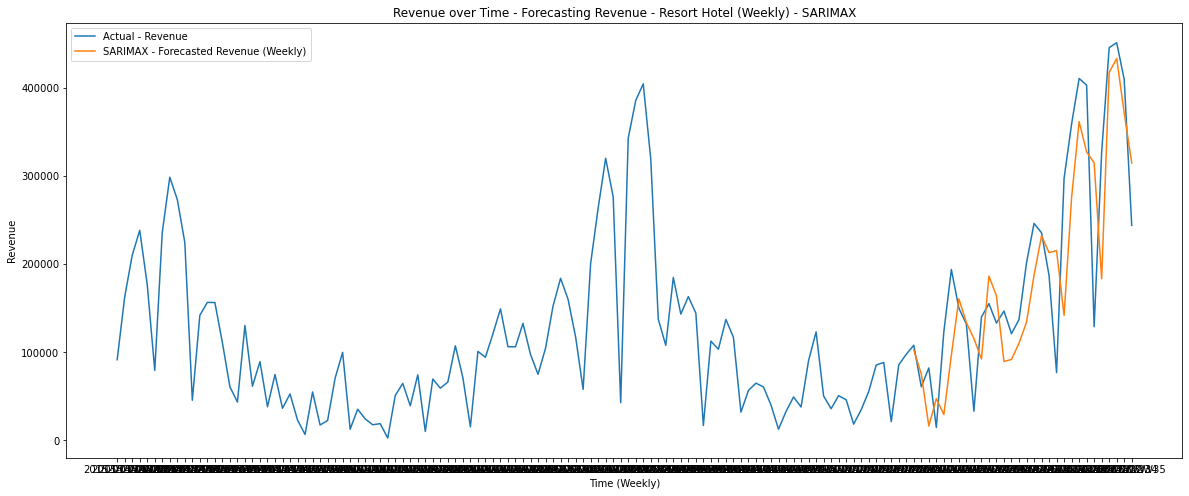

In [70]:
fig, ax = plt.subplots(figsize=(20, 8))

sns.color_palette("viridis", as_cmap=True)
sns.lineplot(data=df_cleaned_datetime_resort_weekly_grouped, label='Actual - Revenue')
sns.lineplot(data=forecast_resort_weekly_sarimax_test, label='SARIMAX - Forecasted Revenue (Weekly)')

ax.set_title('Revenue over Time - Forecasting Revenue - Resort Hotel (Weekly) - SARIMAX')
ax.set_xlabel('Time (Weekly)')
ax.set_ylabel('Revenue')
ax.legend(loc='upper left')

plt.show()

In [71]:
mae_resort_weekly_sarimax = mean_absolute_error(df_cleaned_datetime_resort_weekly_grouped_test,forecast_resort_weekly_sarimax_test)
mse_resort_weekly_sarimax = mean_squared_error(df_cleaned_datetime_resort_weekly_grouped_test,forecast_resort_weekly_sarimax_test)
rmse_resort_weekly_sarimax = mean_squared_error(df_cleaned_datetime_resort_weekly_grouped_test,forecast_resort_weekly_sarimax_test, squared=False)

# Print the evaluation metrics
print("Resort Hotel (Weekly) - SARIMAX - Evaluating Resort Hotel (Daily) - Revenue Forecasting:")
print(f"Resort Hotel (Weekly) - SARIMAX - Mean Absolute Error: {mae_resort_weekly_sarimax}.")
print(f"Resort Hotel (Weekly) - SARIMAX - Mean Squared Error: {mse_resort_weekly_sarimax}.")
print(f"Resort Hotel (Weekly) - SARIMAX - Root Mean Squared Error: {rmse_resort_weekly_sarimax}.")

Resort Hotel (Weekly) - SARIMAX - Evaluating Resort Hotel (Daily) - Revenue Forecasting:
Resort Hotel (Weekly) - SARIMAX - Mean Absolute Error: 59020.48295086737.
Resort Hotel (Weekly) - SARIMAX - Mean Squared Error: 5666949516.970212.
Resort Hotel (Weekly) - SARIMAX - Root Mean Squared Error: 75279.14397075867.


### __9. SARIMAX - City Hotel (Weekly)__

In [72]:
df_cleaned_datetime_city_weekly = df_cleaned[df_cleaned['hotel']=='City Hotel'][['arrival_date','revenue']]
df_cleaned_datetime_city_weekly.sort_values(by='arrival_date', ascending=True, inplace=True)

In [73]:
df_cleaned_datetime_city_weekly['arrival_year_month_week'] = df_cleaned_datetime_city_weekly['arrival_date'].dt.strftime('%Y-%m-W%U')
df_cleaned_datetime_city_weekly.drop(axis=1,columns='arrival_date',inplace=True)
df_cleaned_datetime_city_weekly.sort_values(by='arrival_year_month_week', ascending=True, inplace=True)
df_cleaned_datetime_city_weekly.head()

,revenue,arrival_year_month_week
40060,0.0,2015-07-W26
40065,229.5,2015-07-W26
73718,125.6,2015-07-W26
73723,125.6,2015-07-W26
73724,125.6,2015-07-W26


In [74]:
df_cleaned_datetime_city_weekly_grouped = df_cleaned_datetime_city_weekly.groupby(by='arrival_year_month_week')['revenue'].sum()
df_cleaned_datetime_city_weekly_grouped.info()

<class 'pandas.core.series.Series'>
Index: 136 entries, 2015-07-W26 to 2017-08-W35
Series name: revenue
Non-Null Count  Dtype  
--------------  -----  
136 non-null    float64
dtypes: float64(1)
memory usage: 2.1+ KB


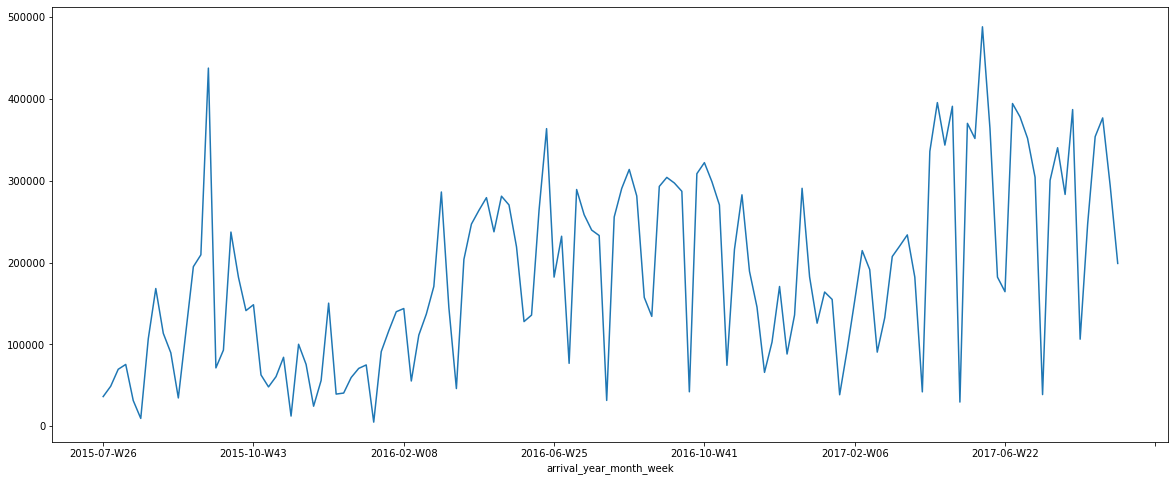

In [75]:
fig, ax = plt.subplots(figsize=(20, 8))
df_cleaned_datetime_city_weekly_grouped.plot()
plt.show()

In [76]:
# We want to train on historical data and forecast later dates

# Time Unit: Weekly
df_cleaned_datetime_city_weekly_grouped_train = df_cleaned_datetime_city_weekly_grouped[:106]
df_cleaned_datetime_city_weekly_grouped_test = df_cleaned_datetime_city_weekly_grouped[106:]

In [77]:
model_city_weekly_sarimax = SARIMAX(df_cleaned_datetime_city_weekly_grouped, order=(2,1,2), seasonal_order=(2,1,2,12), trend='ct')
model_city_weekly_sarimax_fit = model_city_weekly_sarimax.fit()

print(model_city_weekly_sarimax_fit.summary())

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                            revenue   No. Observations:                  136
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood               -1601.425
Date:                            Mon, 20 Mar 2023   AIC                           3224.850
Time:                                    21:19:50   BIC                           3255.784
Sample:                                         0   HQIC                          3237.415
                                            - 136                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -9689.5386   1.76e+04     -0.552      0.581   -4.41e+04    2.47e+04
drift        112.2862    214.864   

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot:xlabel='arrival_year_month_week'>

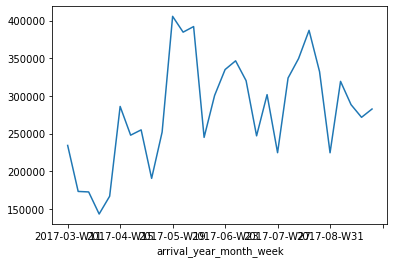

In [78]:
# Time Unit: Monthly
forecast_city_weekly_sarimax_test = model_city_weekly_sarimax_fit.predict(start=len(df_cleaned_datetime_city_weekly_grouped_train),
                                                                                end=len(df_cleaned_datetime_city_weekly_grouped_train)+len(df_cleaned_datetime_city_weekly_grouped_test)-1)
forecast_city_weekly_sarimax_test.plot()

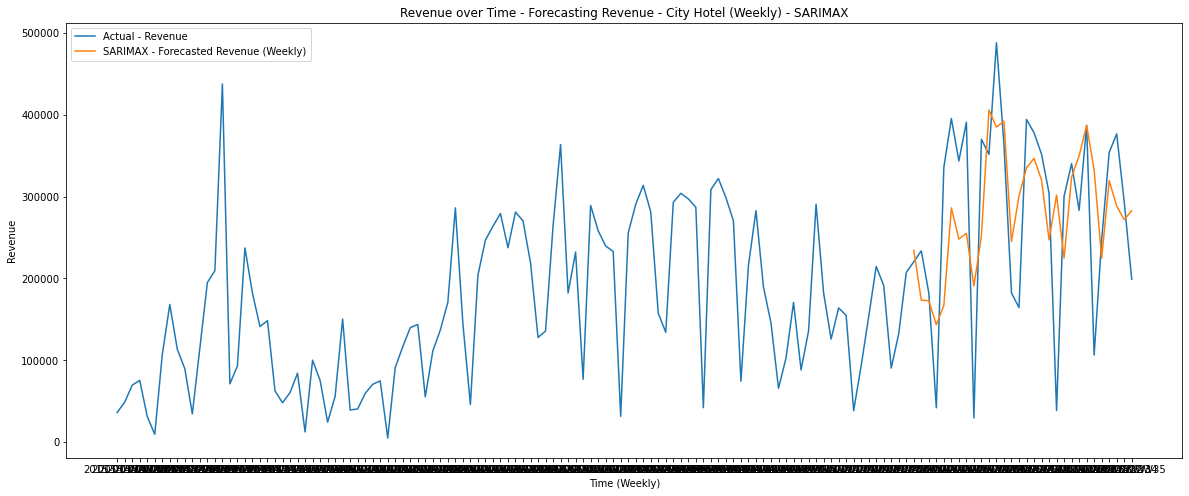

In [79]:
fig, ax = plt.subplots(figsize=(20, 8))

sns.color_palette("viridis", as_cmap=True)
sns.lineplot(data=df_cleaned_datetime_city_weekly_grouped, label='Actual - Revenue')
sns.lineplot(data=forecast_city_weekly_sarimax_test, label='SARIMAX - Forecasted Revenue (Weekly)')

ax.set_title('Revenue over Time - Forecasting Revenue - City Hotel (Weekly) - SARIMAX')
ax.set_xlabel('Time (Weekly)')
ax.set_ylabel('Revenue')
ax.legend(loc='upper left')

plt.show()

In [80]:
mae_city_weekly_sarimax = mean_absolute_error(df_cleaned_datetime_city_weekly_grouped_test,forecast_city_weekly_sarimax_test)
mse_city_weekly_sarimax = mean_squared_error(df_cleaned_datetime_city_weekly_grouped_test,forecast_city_weekly_sarimax_test)
rmse_city_weekly_sarimax = mean_squared_error(df_cleaned_datetime_city_weekly_grouped_test,forecast_city_weekly_sarimax_test, squared=False)

# Print the evaluation metrics
print("City Hotel (Weekly) - SARIMAX - Evaluating Resort Hotel (Daily) - Revenue Forecasting:")
print(f"City Hotel (Weekly) - SARIMAX - Mean Absolute Error: {mae_city_weekly_sarimax}.")
print(f"City Hotel (Weekly) - SARIMAX - Mean Squared Error: {mse_city_weekly_sarimax}.")
print(f"City Hotel (Weekly) - SARIMAX - Root Mean Squared Error: {rmse_city_weekly_sarimax}.")

City Hotel (Weekly) - SARIMAX - Evaluating Resort Hotel (Daily) - Revenue Forecasting:
City Hotel (Weekly) - SARIMAX - Mean Absolute Error: 81216.71677741648.
City Hotel (Weekly) - SARIMAX - Mean Squared Error: 10518148652.281681.
City Hotel (Weekly) - SARIMAX - Root Mean Squared Error: 102558.02578190398.


Let's evaluate the __SARIMAX Models for Resort Hotel vs. City Hotel for Daily vs. Weekly.__

- To allow equal comparison, we will take Daily vs. Weekly / 7, to bring it down to a daily comparison.

In [81]:
# Print the evaluation metrics

print(f"Resort Hotel (Daily) - ARIMA - RMSE {rmse_resort_daily_arima}.")
print(f"Resort Hotel (Daily) - SARIMAX - RMSE {rmse_resort_daily_sarimax}.")
print(f"Resort Hotel (Weekly) - SARIMAX - RMSE {rmse_resort_weekly_sarimax}, after aggregation = {rmse_resort_weekly_sarimax/7}.")
print()
print(f"City Hotel (Daily) - ARIMA - RMSE {rmse_city_daily_arima}.")
print(f"City Hotel (Daily) - SARIMAX - RMSE {rmse_city_daily_sarimax}.")
print(f"City Hotel (Weekly) - SARIMAX - RMSE {rmse_city_weekly_sarimax}, after aggregation = {rmse_city_weekly_sarimax/7}.")

Resort Hotel (Daily) - ARIMA - RMSE 31726.83947999906.
Resort Hotel (Daily) - SARIMAX - RMSE 15965.68282474732.
Resort Hotel (Weekly) - SARIMAX - RMSE 75279.14397075867, after aggregation = 10754.163424394095.

City Hotel (Daily) - ARIMA - RMSE 28342.23522711075.
City Hotel (Daily) - SARIMAX - RMSE 19953.03354823791.
City Hotel (Weekly) - SARIMAX - RMSE 102558.02578190398, after aggregation = 14651.146540271997.


### __Quick Summary:__

As we can see, our __SARIMAX model _(evaluated weekly)_ performs better at forecasting "revenue".__

- Resort Hotel (Daily) - SARIMAX - RMSE 15,965.6828.
- __Resort Hotel (Weekly) - SARIMAX__ - RMSE, after aggregation = 10,754.1634 _(this is better)_.
- City Hotel (Daily) - SARIMAX - RMSE 19,953.0335.
- __City Hotel (Weekly) - SARIMAX__ - RMSE after aggregation = 14,651.1465 _(this is better)_.

Morever, earlier when we looked at the summary statistics for "revenue" for both Resort Hotel vs. City Hotel:
- Resort Hotel Revenue Standard Deviation: 18,661.52, our SARIMAX model above is within this std dev.
- City Hotel Revenue Standard Deviation: 19,479.66, similarly our SARIMAX model above is within this std dev.

### __Business Action for Upper Funnel - Awareness__

- From the median Lead Time and forecasted potential sale, we can determine our marketing budget, as a percentage of spend, for that period to advertise.

### __End of Upper Funnel - Awareness Section.__